In [1]:
import warnings
warnings.simplefilter("ignore")

import mlflow
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from simulation_study_analysis_helpers import *

# move to project root directory to find the mlruns folder with mlflow experiments
notebook_path = Path().resolve()
project_root = notebook_path.parent  # adjust as needed
os.chdir(project_root)

from simulation_studies.generate_synthetic_vine_data import generate_synthetic_vine_data

### Demo on how to analyse MLFlow Stored Experiments

1. Below we move to the root of the project where the mlruns folder is. There we can then call experiment wise run data. MLFlow allows us to look at tags, parameters as well as metrics in a pandas dataframe and hence create plots across runs. See minimal example below.

2. All Tags, Parameters, Metrics and Artifacts (Every Datatype, manely Plots and the Model) can also be viewed using the MLFlow User Interface which is a server you run locally. Simply open a new terminal and run "mlflow ui", then the server runs in that terminal and you can see it in the browser under "http://127.0.0.1:5000" (can be changed by a comand). Server can be closed by closing the terminal and running "pkill -f mlflow" in another terminal.

3. The only annoying thing about mlflow is that is uses absolute instead of relative paths. This means that if you want to analyze results created on another machine (server or another person) then it does not work. However I have coded a workaround that patches the paths. To solve this simply run the python script "/simulation_studies/mlflow_change_mlflow_artifact_directiories.py" in a terminal.


In [2]:
experiment_name = "rine_10D_500obs_bootstrap_hydra_fixed_copula_smaller_penlasso_adpative"
experiment = mlflow.get_experiment_by_name(experiment_name) 
df_runs = mlflow.search_runs([experiment.experiment_id])

# subset all runs seed smaller 32
df_runs = df_runs[df_runs["tags.seed_value"].astype(int) < 33]


df_structure = generate_synthetic_vine_data(seed_value=0,seed_value_copula=int(df_runs["tags.seed_value_copula"].iloc[0]))["df_true_structure"]

model fit to true distribution in original samples and bootstrap samples

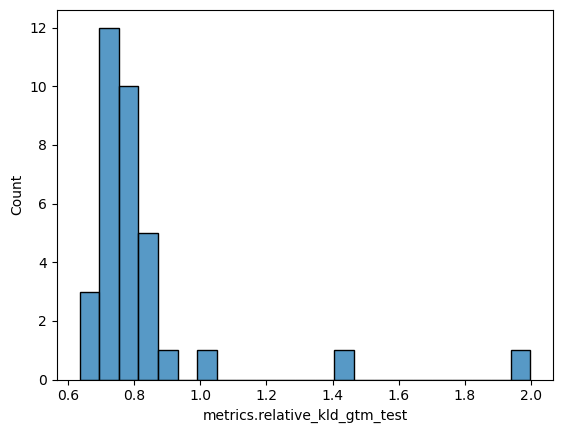

mean  0.824785294117647
mode  0.7676000000000001


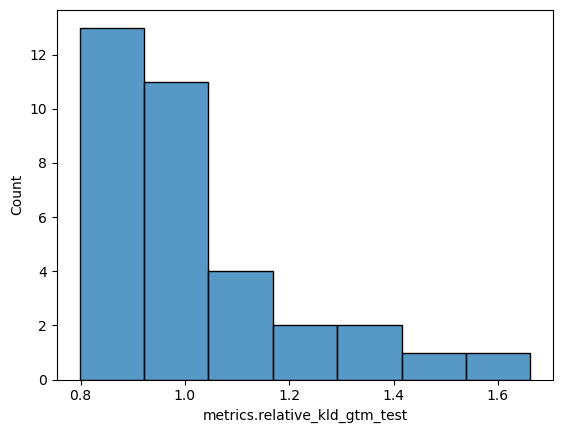

mean  1.0254176470588237
mode  0.9540500000000001


In [3]:
bootstrap_bool = df_runs["tags.mlflow.runName"].str.contains("bootstrap")
df_run_originals_only = df_runs[~bootstrap_bool]


sns.histplot(data=df_run_originals_only, x="metrics.relative_kld_gtm_test")
plt.show()

print("mean ", df_run_originals_only["metrics.relative_kld_gtm_test"].mean())
print("mode ", df_run_originals_only["metrics.relative_kld_gtm_test"].quantile(0.5))

df_run_bootstrap_only = df_runs[bootstrap_bool]


sns.histplot(data=df_run_bootstrap_only, x="metrics.relative_kld_gtm_test")
plt.show()

print("mean ", df_run_bootstrap_only["metrics.relative_kld_gtm_test"].mean())
print("mode ", df_run_bootstrap_only["metrics.relative_kld_gtm_test"].quantile(0.5))

check out penalties chosen

(-5.0, 35.0)

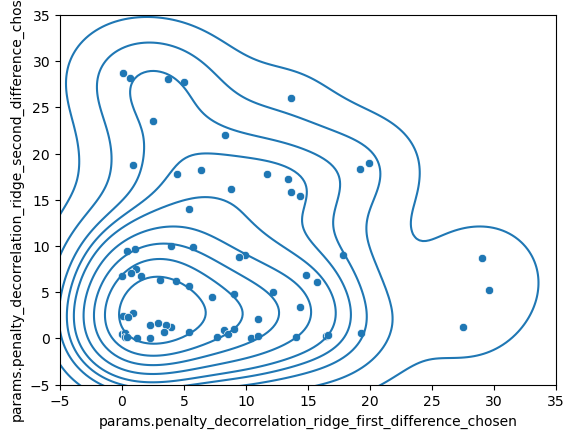

In [4]:
cols = [
    "params.penalty_decorrelation_ridge_first_difference_chosen",
    "params.penalty_decorrelation_ridge_second_difference_chosen",
]
df_runs[cols] = df_runs[cols].astype(float)

sns.kdeplot(data=df_runs, x="params.penalty_decorrelation_ridge_first_difference_chosen", y="params.penalty_decorrelation_ridge_second_difference_chosen")
sns.scatterplot(data=df_runs, x="params.penalty_decorrelation_ridge_first_difference_chosen", y="params.penalty_decorrelation_ridge_second_difference_chosen")
plt.ylim(-5,35)
plt.xlim(-5,35)

In [5]:
import torch
df_runs.loc[:, "params.penalty_lasso_conditional_independence_chosen"]

4      0.0035140456166118383
5       0.005529501941055059
6     4.0337863538297825e-07
7      0.0003246020642109215
8      0.0007216850062832236
               ...          
67     8.014452760107815e-06
68     6.320542524917983e-07
69      1.48961562445038e-05
70     0.0005968657205812633
71     0.0024104772601276636
Name: params.penalty_lasso_conditional_independence_chosen, Length: 68, dtype: object

## Training and Validation Samples based Analysis: Likelihood Ratio Statistic

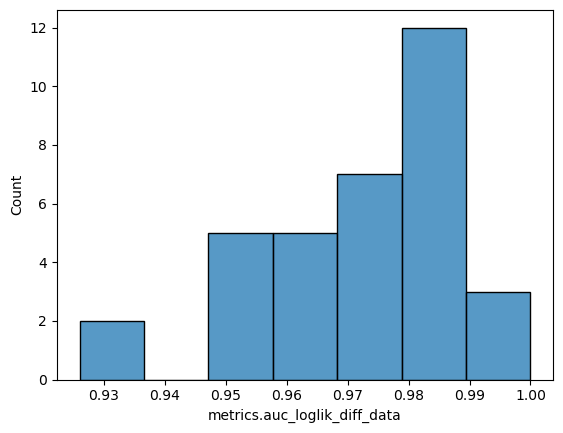

mean  0.9717251606524964
mode  0.9762605042016808


In [6]:
sns.histplot(data=df_run_originals_only, x="metrics.auc_loglik_diff_data")
plt.show()

print("mean ", df_run_originals_only["metrics.auc_loglik_diff_data"].mean())
print("mode ", df_run_originals_only["metrics.auc_loglik_diff_data"].quantile(0.5))

In [7]:
table_diffs_list, table_original_dict = get_data_original_and_bootstrap(df_runs,data="training_and_validation")
plot_metric_percentage_above_zero_bootstrap_intervals_across_seeds(df_runs,table_original_dict,table_diffs_list,df_structure,metric="kld")

ValueError: can only convert an array of size 1 to a Python scalar

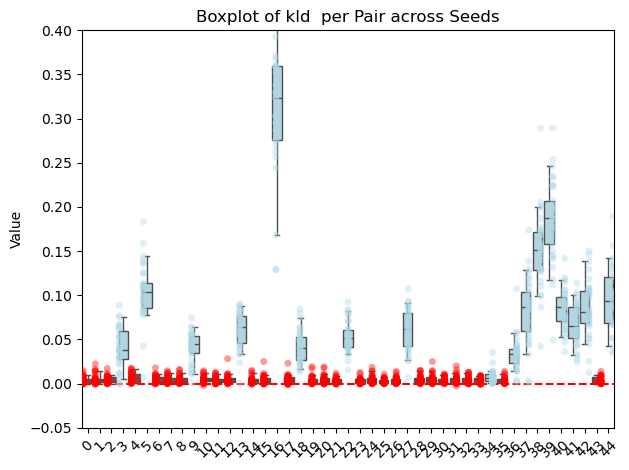

In [ ]:
plot_metric_values_across_seeds(df_runs,table_original_dict,df_structure,metric="kld",ylim=(-0.05,0.4))

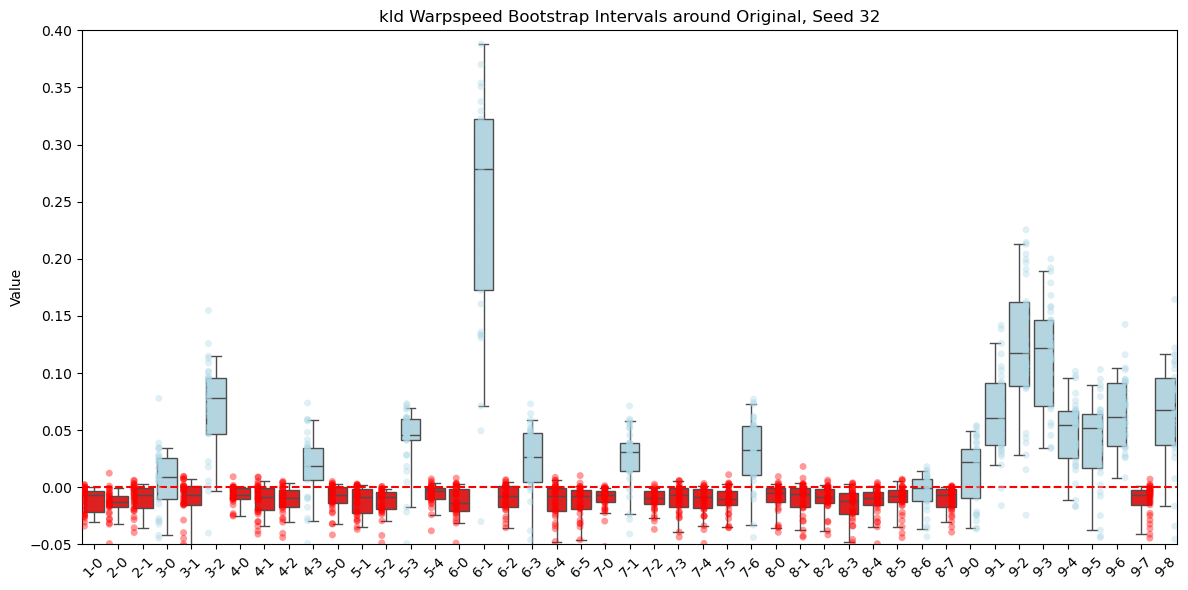

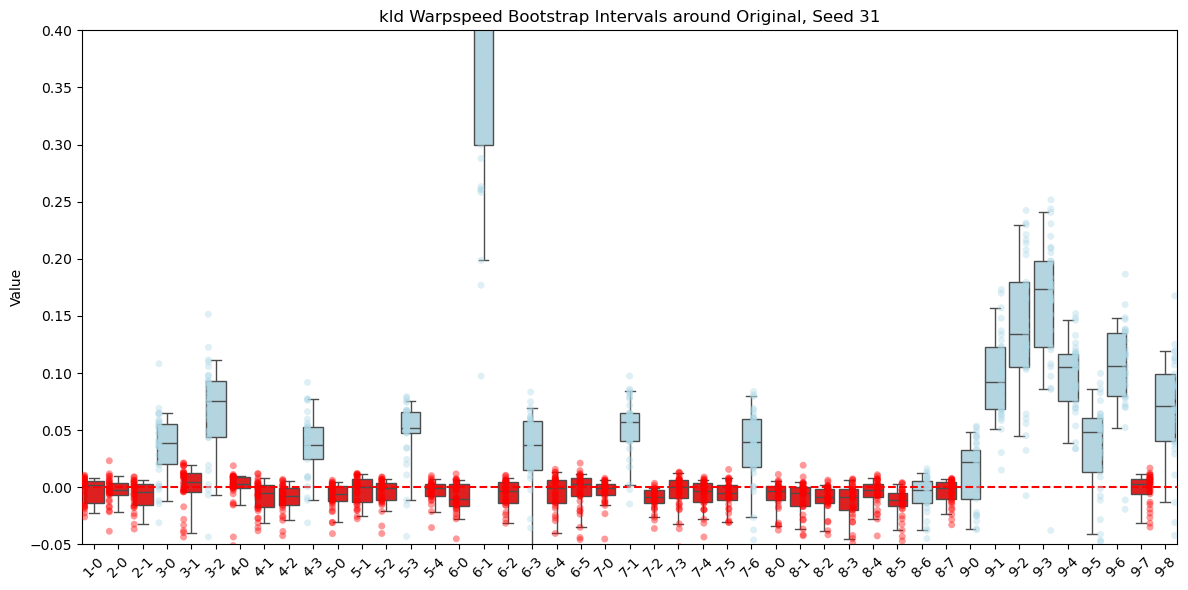

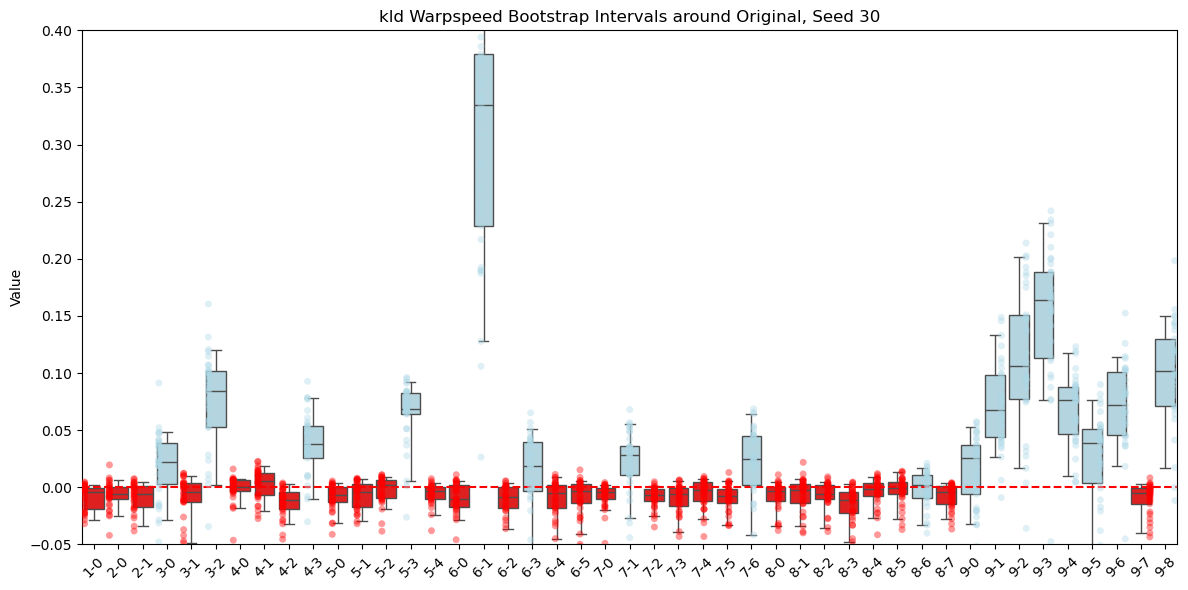

In [ ]:
plot_metric_bootstrap_intervals_for_each_seed(df_runs[:6],table_original_dict,table_diffs_list,df_structure,metric="kld",ylim=(-0.05,0.4))

## Synthetic Samples based Analysis: IAE between estimated GTM and itsself under CI

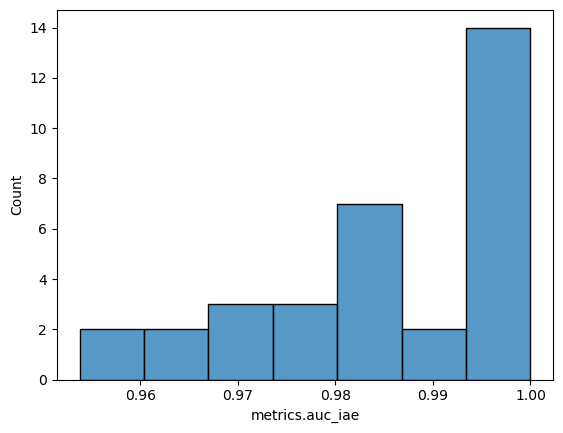

mean  0.9848484848484849
mode  0.9852941176470589


In [ ]:
sns.histplot(data=df_run_originals_only, x="metrics.auc_iae")
plt.show()

print("mean ", df_run_originals_only["metrics.auc_iae"].mean())
print("mode ", df_run_originals_only["metrics.auc_iae"].quantile(0.5))

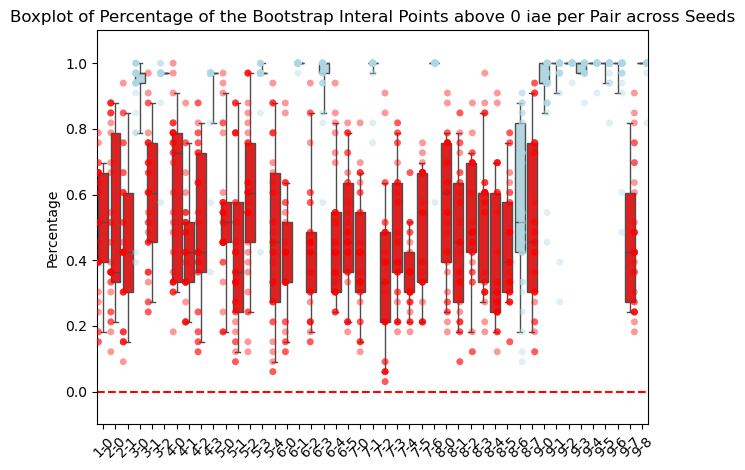

In [ ]:
table_diffs_list, table_original_dict = get_data_original_and_bootstrap(df_runs,data="synthetic")
plot_metric_percentage_above_zero_bootstrap_intervals_across_seeds(df_runs,table_original_dict,table_diffs_list,df_structure,metric="iae")

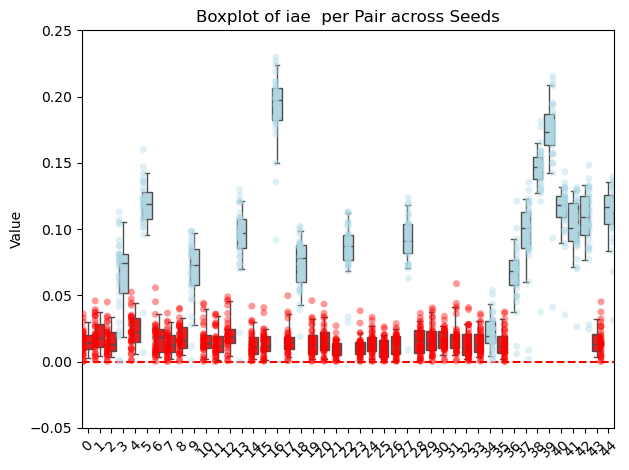

In [ ]:
plot_metric_values_across_seeds(df_runs,table_original_dict,df_structure,metric="iae",ylim=(-0.05,0.25))

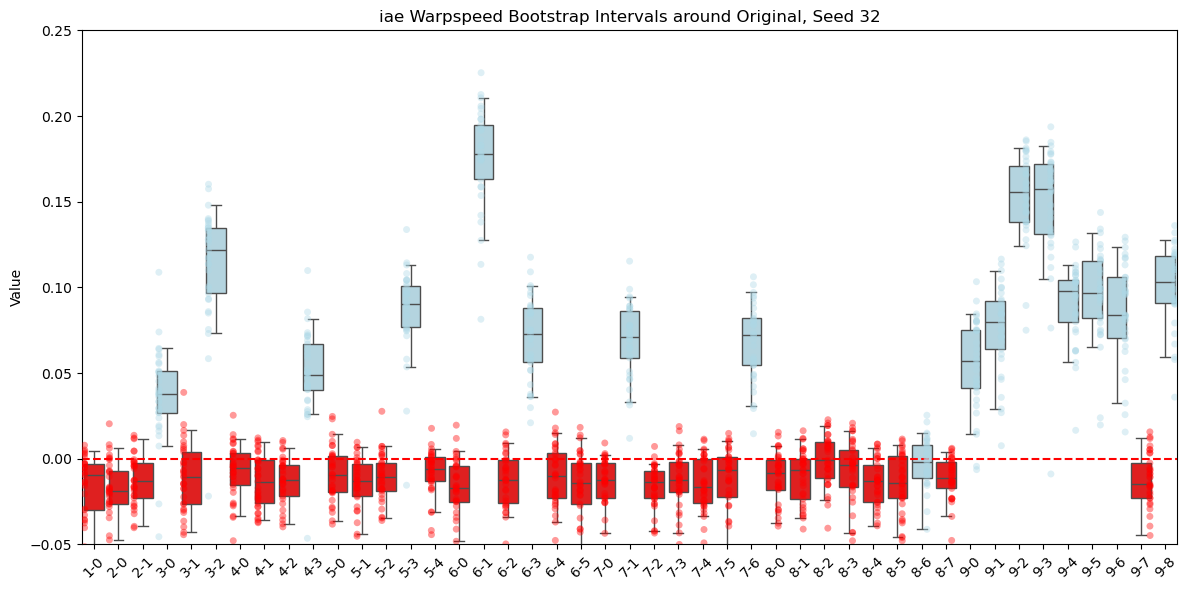

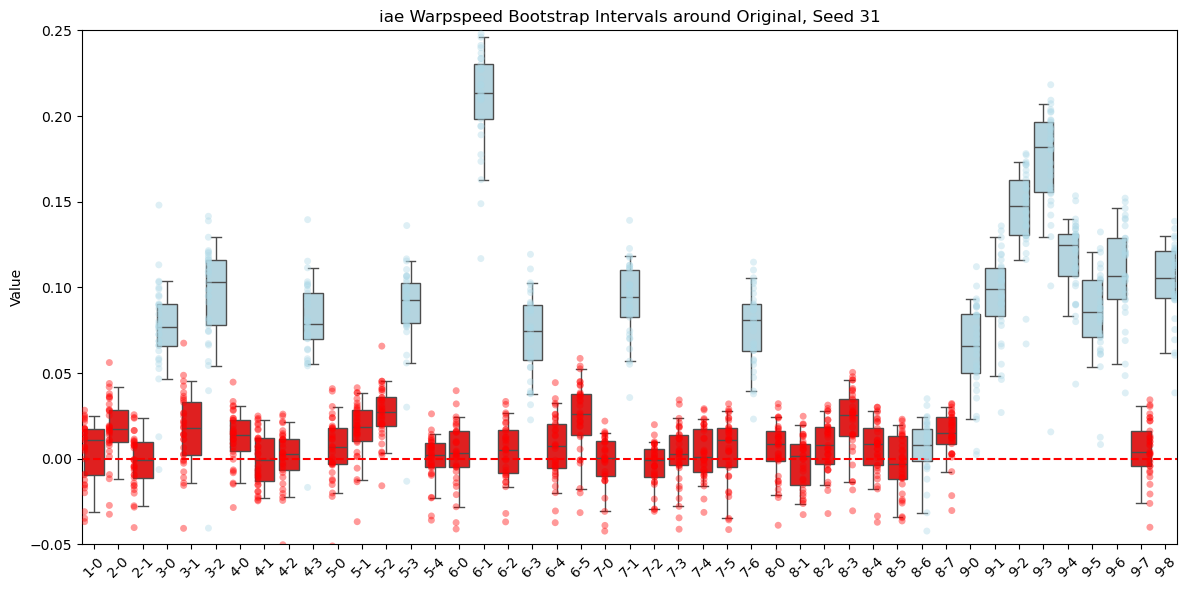

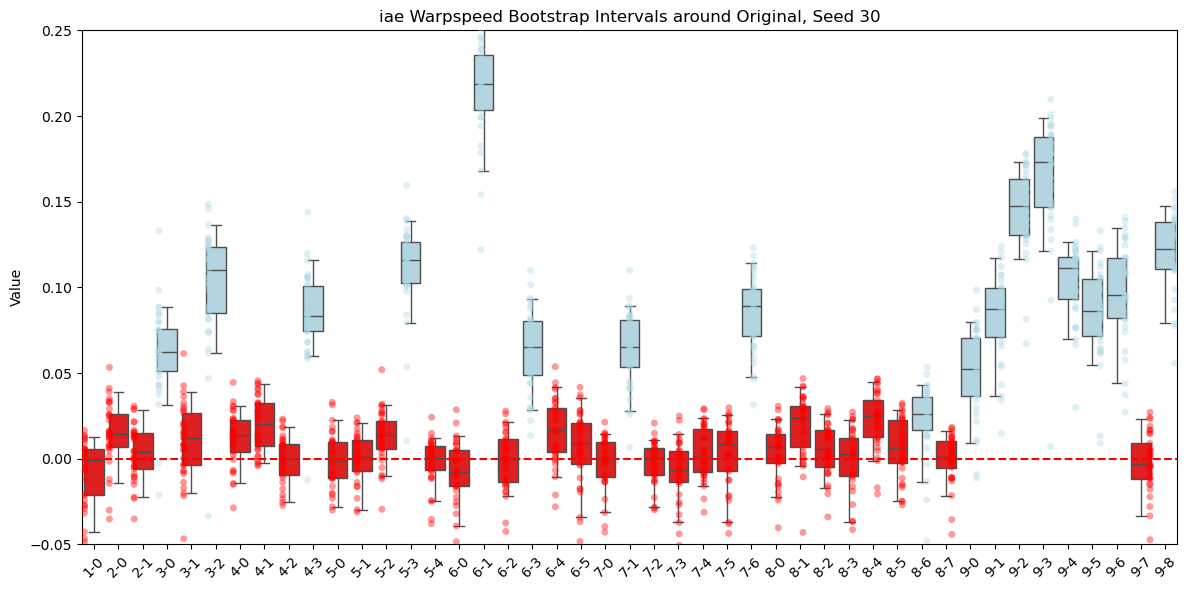

In [ ]:
plot_metric_bootstrap_intervals_for_each_seed(df_runs[:6],table_original_dict,table_diffs_list,df_structure,metric="iae")

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

table_diffs_list, table_original_dict = get_data_original_and_bootstrap(df_runs,data="training_and_validation")

df_structure = generate_synthetic_vine_data(seed_value=0,
                                            seed_value_copula=int(df_runs["tags.seed_value_copula"].iloc[0]),
                                            dimensionality=int(df_runs["tags.dimensionality"].iloc[0])
                                            )["df_true_structure"]
df_structure.sort_values(by=['var_row', 'var_col'], inplace=True)

counter=0
for key in list(table_original_dict.keys()):
    
    table_original_dict[key].sort_values(by=['var_row', 'var_col'], inplace=True)

    precision, recall, thresholds = precision_recall_curve(df_structure.loc[:,"dependence"], 
                                                        table_original_dict[key].loc[:,"kld"])

    if counter == 0:
        precision_total = precision.reshape(1,46)
        #recall_total = recall
        counter=1
    else:
        precision_total = np.concatenate((precision_total,precision.reshape(1,46)),axis=0)
        #recall_total = np.stack((recall_total,recall),axis=0)


mean_precision = np.mean(precision_total, axis=0)
lower = np.min(precision_total, axis=0) #np.percentile(precision_total, 0, axis=0)
upper = np.max(precision_total, axis=0) #np.percentile(precision_total, 100, axis=0)

    
# ---- Plot mean and fill between confidence interval ----
plt.plot(recall, mean_precision, marker=".", label=key)
plt.fill_between(recall, lower, upper, alpha=0.2)

#####################################################################################################################################################

table_diffs_list, table_original_dict = get_data_original_and_bootstrap(df_runs,data="synthetic")

df_structure = generate_synthetic_vine_data(seed_value=0,
                                            seed_value_copula=int(df_runs["tags.seed_value_copula"].iloc[0]),
                                            dimensionality=int(df_runs["tags.dimensionality"].iloc[0])
                                            )["df_true_structure"]
df_structure.sort_values(by=['var_row', 'var_col'], inplace=True)

counter=0
for key in list(table_original_dict.keys()):
    
    table_original_dict[key].sort_values(by=['var_row', 'var_col'], inplace=True)

    precision, recall, thresholds = precision_recall_curve(df_structure.loc[:,"dependence"], 
                                                        table_original_dict[key].loc[:,"iae"])

    if counter == 0:
        precision_total = precision.reshape(1,46)
        #recall_total = recall
        counter=1
    else:
        precision_total = np.concatenate((precision_total,precision.reshape(1,46)),axis=0)
        #recall_total = np.stack((recall_total,recall),axis=0)


mean_precision = np.mean(precision_total, axis=0)
lower = np.min(precision_total, axis=0) #np.percentile(precision_total, 0, axis=0)
upper = np.max(precision_total, axis=0) #np.percentile(precision_total, 100, axis=0)

    
# ---- Plot mean and fill between confidence interval ----
plt.plot(recall, mean_precision, marker=".", label=key)
plt.fill_between(recall, lower, upper, alpha=0.2)


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

ValueError: can only convert an array of size 1 to a Python scalar